<a href="https://colab.research.google.com/github/NooraAlsaiari077/DataMiningProject/blob/main/Phase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


                              1. DATA ANALYSIS:

=== Five-number summary (numeric attributes) ===

                   min     Q1  median    Q3    max
Sex                0.0   0.00     0.0   1.0    1.0
School Code        1.0   2.00     4.0   8.0   11.0
Playing Years      0.0   0.00     1.0   3.0    4.0
Playing Often      0.0   0.00     2.0   4.0    5.0
Playing Hours      0.0   0.00     1.0   2.0    5.0
Playing Games      0.0   0.00     1.0   1.0    2.0
Parent Revenue     0.0   1.00     2.0   2.0    4.0
Father Education   0.0   3.00     4.0   5.0    6.0
Mother Education   0.0   2.25     3.0   4.0    6.0
Grade_clean       33.0  65.00    80.0  90.0  100.0





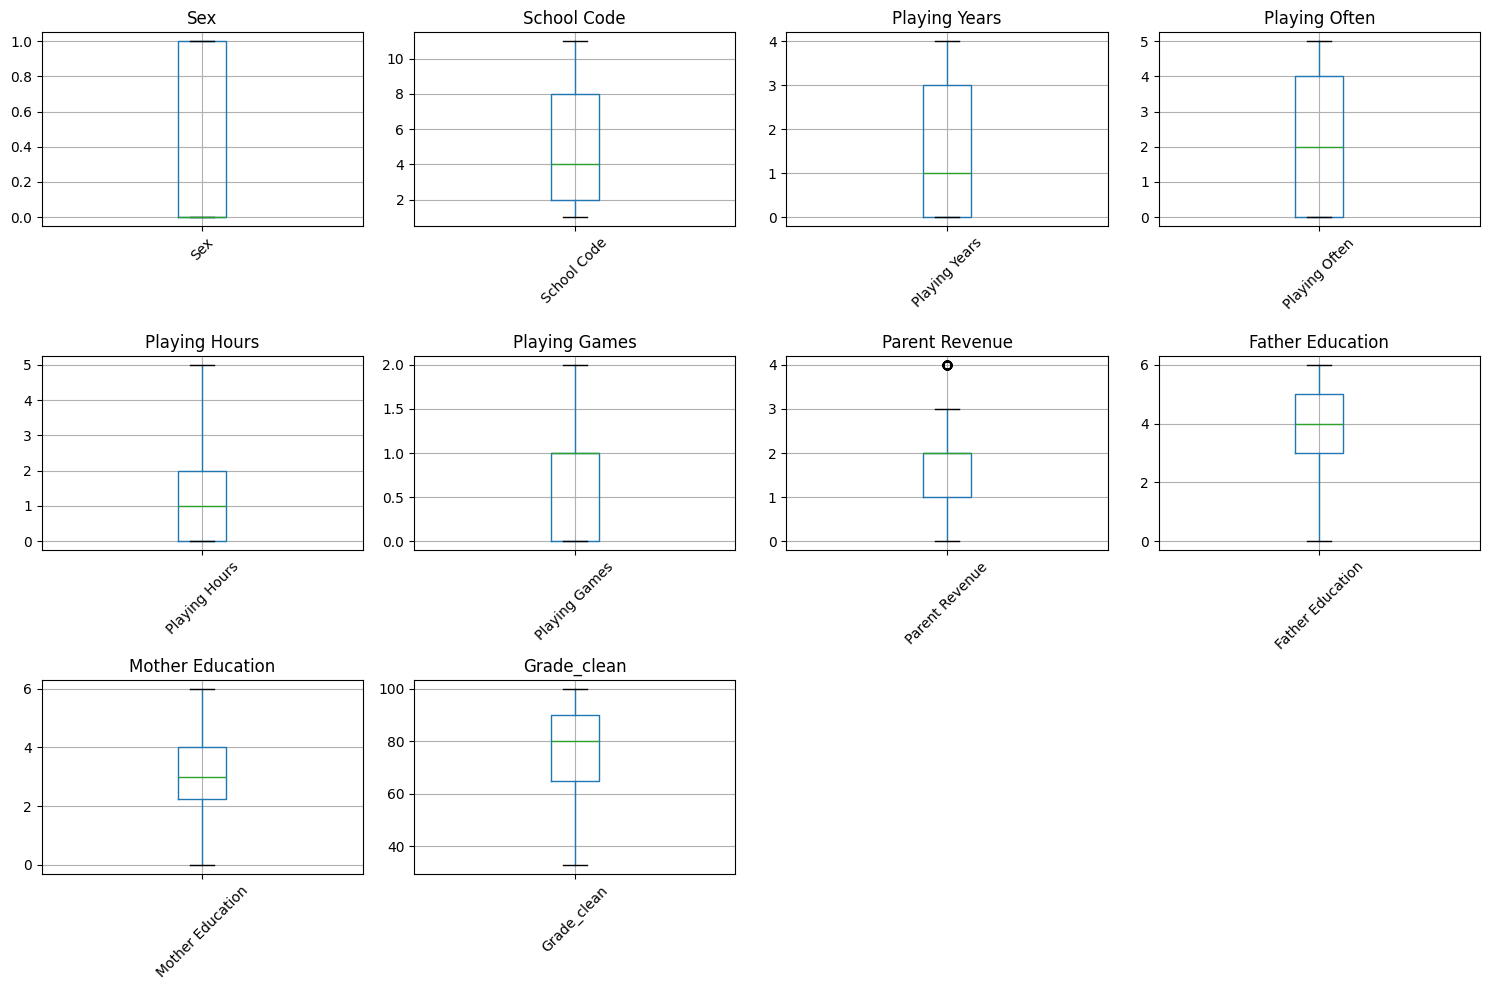


What Can We Understand From The Graphs?
1-Grade distribution shows some extreme values that might be outliers
 But knowing that the range of grades is from 0-100 there could be no actull outliers.
2-Playing Hours and Playing Years have limited ranges with potential outliers
3-Education levels (Father and Mother) show reasonable distributions
In conclusion:
Outliers detected in several variables that need investigation




=== Outlier counts per numeric column, IQR rule ===
             column  outliers_count  lower_bound  upper_bound
6    Parent Revenue              50       -0.500        3.500
0               Sex               0       -1.500        2.500
1       School Code               0       -7.000       17.000
2     Playing Years               0       -4.500        7.500
4     Playing Hours               0       -3.000        5.000
3     Playing Often               0       -6.000       10.000
5     Playing Games               0       -1.500        2.500
7  Father Education      

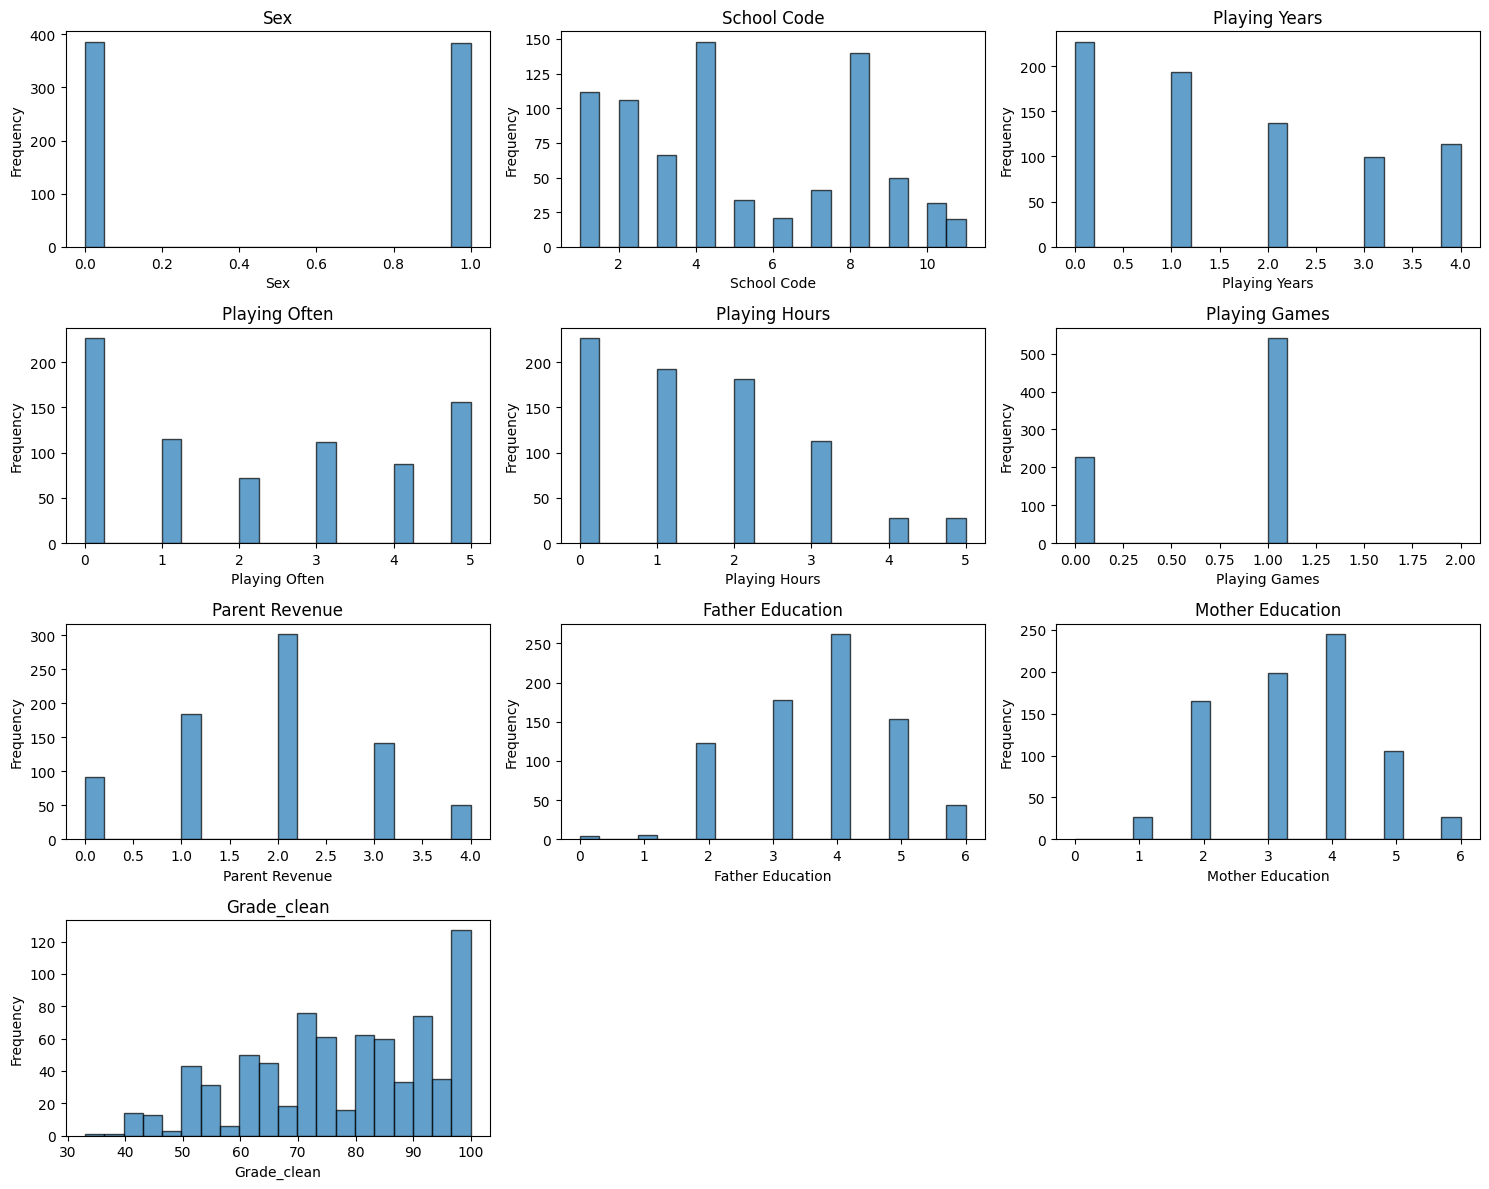


What we understand from the graphs?
1-Grade distribution is somewhat normal but with multiple peaks
2-Playing variables show skewed distributions
3-Education levels are roughly normally distributed
4-School Code distribution is uneven across schools





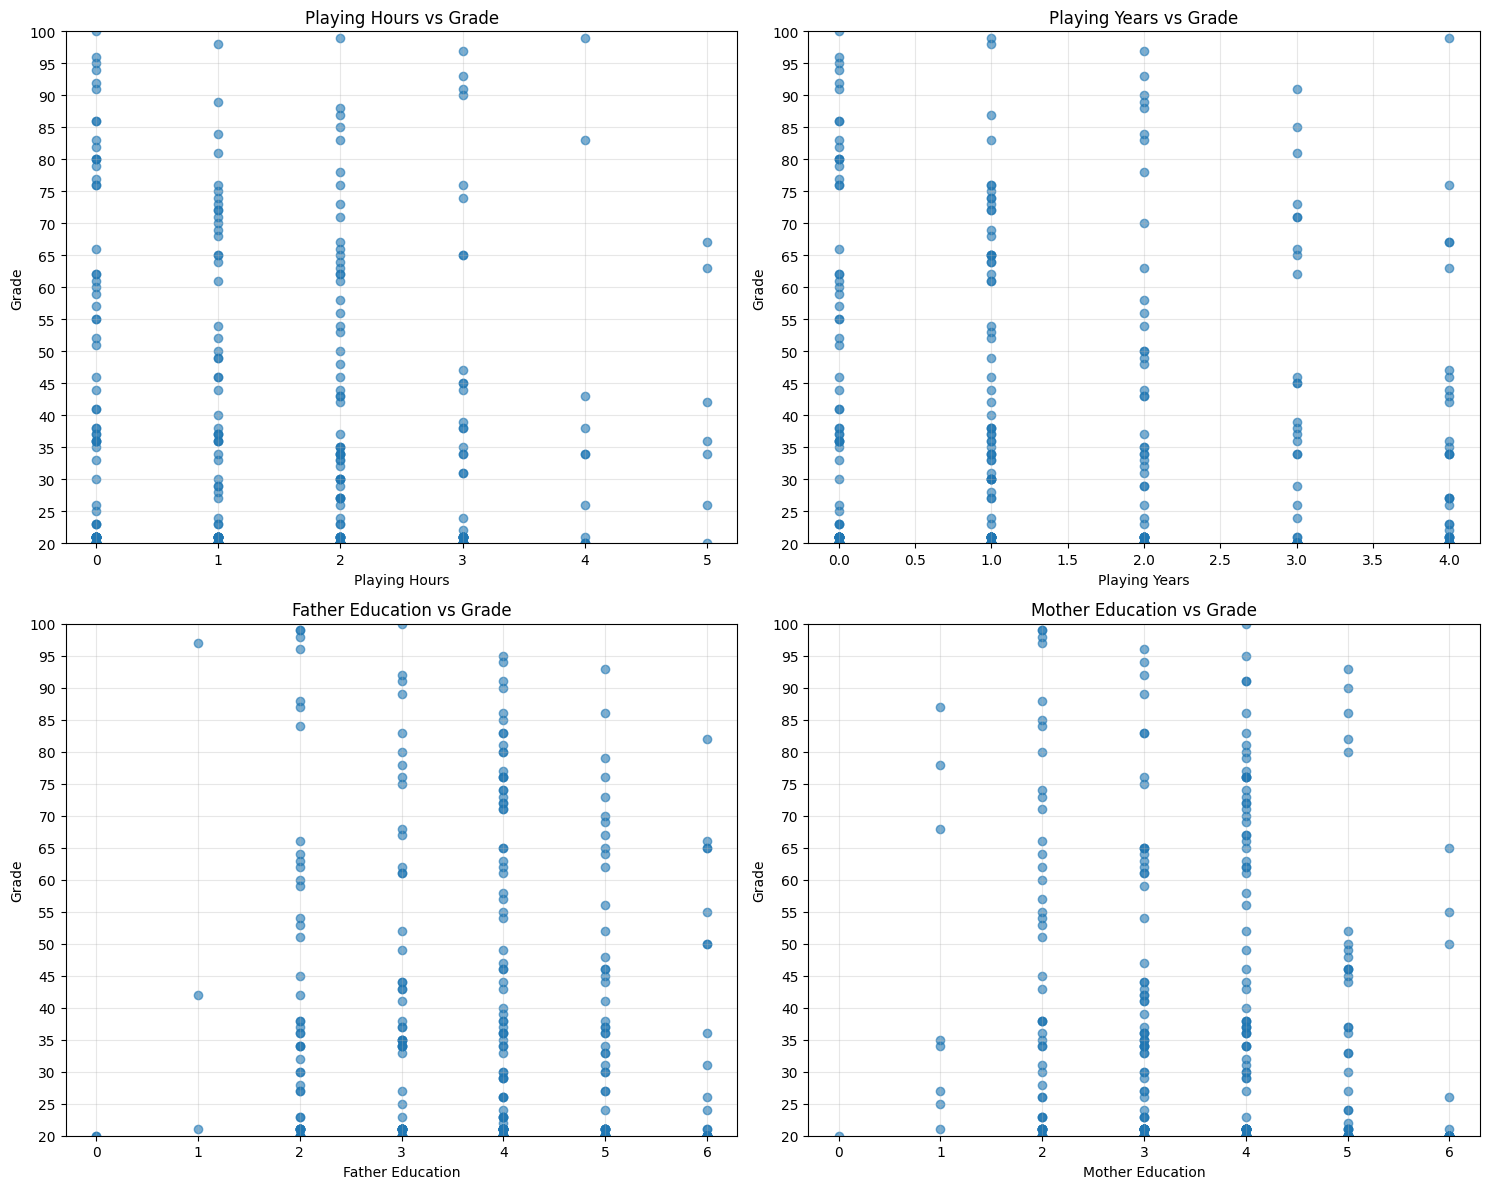


What we understand from the graphs?
1-Weak correlations between gaming habits and grades
2-Education levels show slight positive correlation with grades
3-No strong linear relationships evident between predictors and target variable





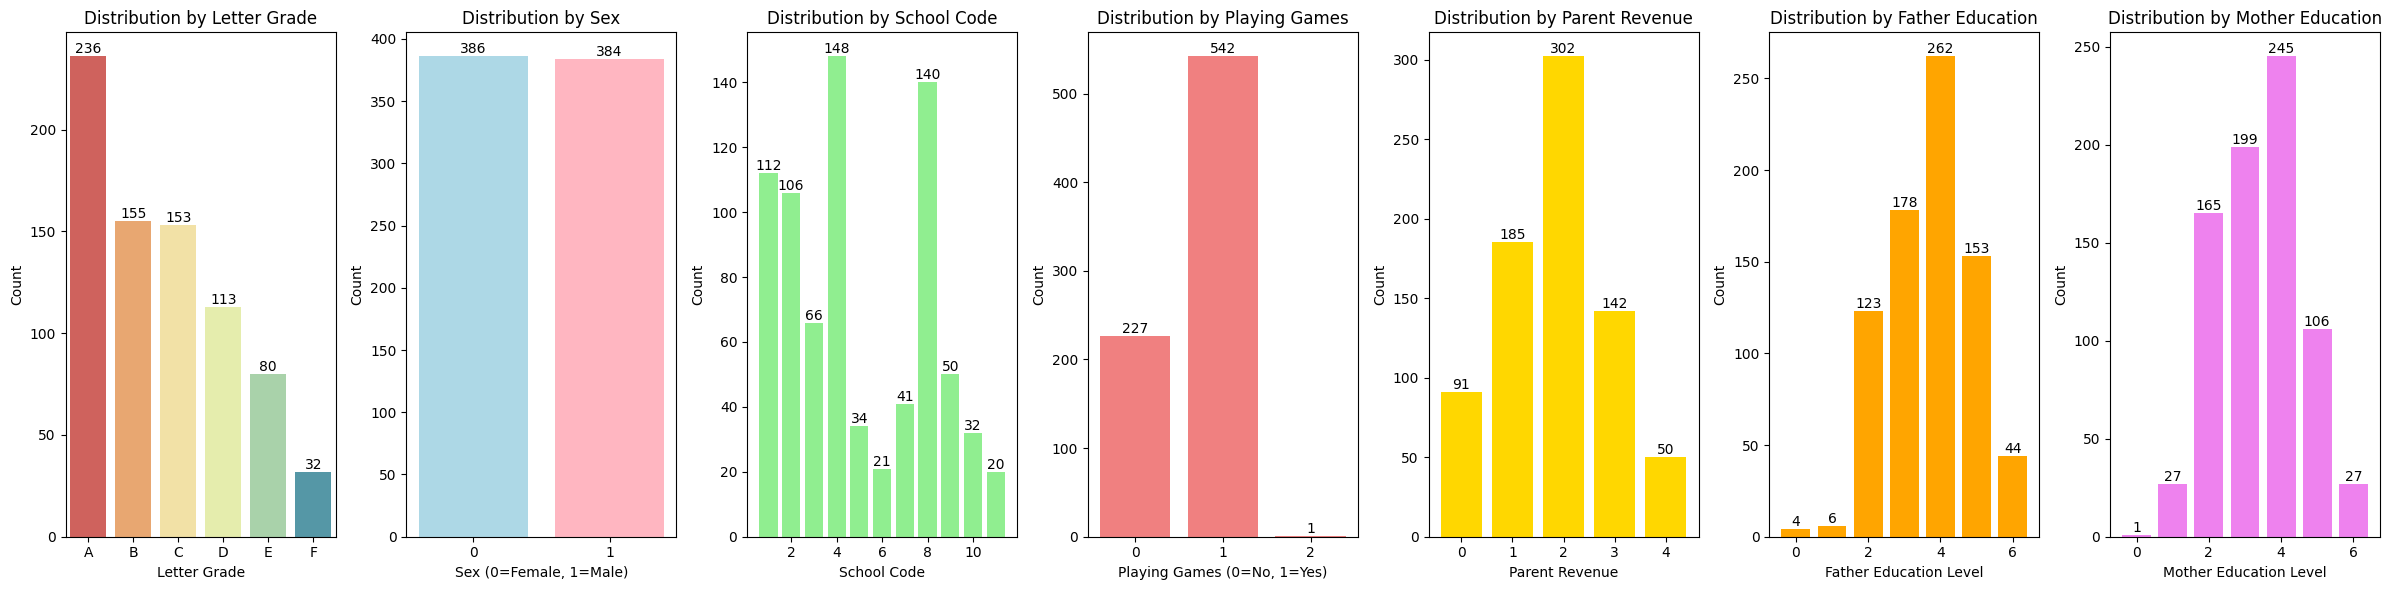


What we understand from the graphs?
1-LetterGrade distribution is shown, revealing the class balance for classification.
2-Balanced gender distribution
3-Uneven school representation - some schools have very few students
4-Most students play games

=== Short preprocessing guidance based on results ===

Skewness(Grade_clean) = -0.351  --> If |skew| > 1, consider a transform; otherwise standardization/robust scaling is fine.
Outliers detected in some numeric columns (IQR). Consider capping (winsorization), transforming, or using robust models.
Missing values present. Use median imputation for numeric, mode for nominal; or drop rows if very few.


                              2. DATA PREPROCESSING:


--- Missing Value Imputation ---
*Imputation applied*



--- Variable Transformation ---
*Encoding Applied*

--- Normalization (Z-score) ---
*Normalization Applied*.

Snapshot of Scaled Data (First 5 rows of scaled features):
   Grade_clean  Playing Hours  Playing Years  Father Education  \

In [1]:
# We added new libararys like for Z-score outlier detection, for Feature Selection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import zscore
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from matplotlib.ticker import ScalarFormatter, MultipleLocator, FixedLocator, MaxNLocator

# Code from phase 1
url = "https://raw.githubusercontent.com/NooraAlsaiari077/DataMiningProject/refs/heads/main/Dataset/Raw_dataset.csv"
df = pd.read_csv(url)
df["Grade_clean"] = pd.to_numeric(df["Grade"], errors="coerce")

def grade_to_letter(x):
    if pd.isna(x): return np.nan
    if x >= 90: return "A"
    if x >= 80: return "B"
    if x >= 70: return "C"
    if x >= 60: return "D"
    if x >= 50: return "E"
    return "F"
df["LetterGrade"] = df["Grade_clean"].apply(grade_to_letter)


#-------------------------------------------------------------------------------------------------------------------------------------------------

# Start of Phase 2

# Define feature lists (used by both Analysis and Preprocessing sections)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
nominal_cols = ["Sex", "Playing Games", "School Code"]

print("\n" + "====================================================================================")
print("                              1. DATA ANALYSIS:")
print("====================================================================================")

# We get the five number summary for each column******************************************************************************************
def five_number_summary(s):
    s = s.dropna()
    return pd.Series({
        "min": s.min(),
        "Q1": np.percentile(s, 25),
        "median": np.percentile(s, 50),
        "Q3": np.percentile(s, 75),
        "max": s.max()
    })

# Table of each column and its five number summary
five_num = df[numeric_cols].apply(five_number_summary)
print("\n=== Five-number summary (numeric attributes) ===\n")
print(five_num.round(3).T)
print("\n\n")

# Loop to draw boxplts for each column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    if col in df.columns:
        plt.subplot(3, 4, i)
        df.boxplot(column=col)
        plt.title(f'{col}')
        plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# What we undersrood from the plots
print("\nWhat Can We Understand From The Graphs?")
print("1-Grade distribution shows some extreme values that might be outliers\n But knowing that the range of grades is from 0-100 there could be no actull outliers.")
print("2-Playing Hours and Playing Years have limited ranges with potential outliers")
print("3-Education levels (Father and Mother) show reasonable distributions")
print("In conclusion:\nOutliers detected in several variables that need investigation")
print("\n\n")


# Outlier detection, IQR rule******************************************************************************************************
outliers = []
for col in numeric_cols:
    s = df[col].dropna()
    if len(s) == 0: continue
    q1, q3 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    count = int(((s < lower) | (s > upper)).sum())
    outliers.append([col, count, lower, upper])

outliers_df = pd.DataFrame(outliers, columns=["column","outliers_count","lower_bound","upper_bound"]).sort_values("outliers_count", ascending=False)
print("\n=== Outlier counts per numeric column, IQR rule ===")
print(outliers_df)
print("\n\n")


# We look for missing values
miss = df.isna().sum().to_frame("missing_count")
miss["missing_pct"] = (miss["missing_count"]/len(df)*100).round(2)
print("\n=== Missing values per column (Analysis) ===")
print(miss.sort_values("missing_count", ascending=False))
print("\n\n")

print("\n=== Statistical summary ===")
print(df.describe(include="all").T)


# Loop to draw the hitogram for each column*************************************************************************************************
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    if col in df.columns:
        plt.subplot(4, 3, i)
        plt.hist(df[col].dropna(), bins=20, alpha=0.7, edgecolor='black')
        plt.title(f'{col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
print("\nWhat we understand from the graphs?")
print("1-Grade distribution is somewhat normal but with multiple peaks")
print("2-Playing variables show skewed distributions")
print("3-Education levels are roughly normally distributed")
print("4-School Code distribution is uneven across schools")
print("\n\n")


# we draw the scatter plot for each 2 columns to understand the relationship between them****************************************************************************************
# we started the range from 20 not 0 since min grade is 33
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0,0].scatter(df['Playing Hours'], df['Grade'], alpha=0.6)
axes[0,0].set_xlabel('Playing Hours')
axes[0,0].set_ylabel('Grade')
axes[0,0].set_title('Playing Hours vs Grade')
axes[0,0].grid(alpha=0.3)
axes[0,0].set_ylim(20, 100)
axes[0,0].set_yticks(np.arange(20, 101, 5))
axes[0,0].tick_params(axis='y', rotation=0)
axes[0,0].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

axes[0,1].scatter(df['Playing Years'], df['Grade'], alpha=0.6)
axes[0,1].set_xlabel('Playing Years')
axes[0,1].set_ylabel('Grade')
axes[0,1].set_title('Playing Years vs Grade')
axes[0,1].grid(alpha=0.3)
axes[0,1].set_ylim(20, 100)
axes[0,1].set_yticks(np.arange(20, 101, 5))
axes[0,1].tick_params(axis='y', rotation=0)
axes[0,1].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

axes[1,0].scatter(df['Father Education'], df['Grade'], alpha=0.6)
axes[1,0].set_xlabel('Father Education')
axes[1,0].set_ylabel('Grade')
axes[1,0].set_title('Father Education vs Grade')
axes[1,0].grid(alpha=0.3)
axes[1,0].set_ylim(20, 100)
axes[1,0].set_yticks(np.arange(20, 101, 5))
axes[1,0].tick_params(axis='y', rotation=0)
axes[1,0].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

axes[1,1].scatter(df['Mother Education'], df['Grade'], alpha=0.6)
axes[1,1].set_xlabel('Mother Education')
axes[1,1].set_ylabel('Grade')
axes[1,1].set_title('Mother Education vs Grade')
axes[1,1].grid(alpha=0.3)
axes[1,1].set_ylim(20, 100)
axes[1,1].set_yticks(np.arange(20, 101, 5))
axes[1,1].tick_params(axis='y', rotation=0)
axes[1,1].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.tight_layout()
plt.show()
print("\nWhat we understand from the graphs?")
print("1-Weak correlations between gaming habits and grades")
print("2-Education levels show slight positive correlation with grades")
print("3-No strong linear relationships evident between predictors and target variable")
print("\n\n")


# we draw the Bar plot for each column and its arrtbute count*******************************************************************************************************************
fig, axes = plt.subplots(1, 7, figsize=(24, 6))
grade_counts = df['LetterGrade'].value_counts().reindex(['A', 'B', 'C', 'D', 'E', 'F']).fillna(0)
sns.barplot(
    x='Grade',
    y='Count',
    data=pd.DataFrame({'Grade': grade_counts.index, 'Count': grade_counts.values}),
    ax=axes[0],
    palette="Spectral",
    hue='Grade', # Add hue
    legend=False # Remove legend
)
axes[0].set_xlabel('Letter Grade')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution by Letter Grade')
for i, v in enumerate(grade_counts.values):
    axes[0].text(i, v, str(int(v)), ha='center', va='bottom')


#Sex distribution
sex_counts = df['Sex'].value_counts()
axes[1].bar(sex_counts.index, sex_counts.values, color=['lightblue', 'lightpink'])
axes[1].set_xlabel('Sex (0=Female, 1=Male)')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution by Sex')
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_xticks([0, 1])
for i, v in enumerate(sex_counts.values):
    axes[1].text(sex_counts.index[i], v, str(v), ha='center', va='bottom')

#School Code distribution
school_counts = df['School Code'].value_counts().sort_index()
axes[2].bar(school_counts.index, school_counts.values, color='lightgreen')
axes[2].set_xlabel('School Code')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution by School Code')
for i, v in enumerate(school_counts.values):
    axes[2].text(school_counts.index[i], v, str(v), ha='center', va='bottom')

#Playing Games distribution
games_counts = df['Playing Games'].value_counts().sort_index()
axes[3].bar(games_counts.index, games_counts.values, color='lightcoral')
axes[3].set_xlabel('Playing Games (0=No, 1=Yes)')
axes[3].set_ylabel('Count')
axes[3].set_title('Distribution by Playing Games')
for i, v in enumerate(games_counts.values):
    axes[3].text(games_counts.index[i], v, str(v), ha='center', va='bottom')

#Parent Revenue distribution
revenue_counts = df['Parent Revenue'].value_counts().sort_index()
axes[4].bar(revenue_counts.index, revenue_counts.values, color='gold')
axes[4].set_xlabel('Parent Revenue')
axes[4].set_ylabel('Count')
axes[4].set_title('Distribution by Parent Revenue')
for i, v in enumerate(revenue_counts.values):
    axes[4].text(revenue_counts.index[i], v, str(v), ha='center', va='bottom')

#Father Education distribution
fedu_counts = df['Father Education'].value_counts().sort_index()
axes[5].bar(fedu_counts.index, fedu_counts.values, color='orange')
axes[5].set_xlabel('Father Education Level')
axes[5].set_ylabel('Count')
axes[5].set_title('Distribution by Father Education')
for i, v in enumerate(fedu_counts.values):
    axes[5].text(fedu_counts.index[i], v, str(v), ha='center', va='bottom')

#Index 6: Mother Education distribution
medu_counts = df['Mother Education'].value_counts().sort_index()
axes[6].bar(medu_counts.index, medu_counts.values, color='violet')
axes[6].set_xlabel('Mother Education Level')
axes[6].set_ylabel('Count')
axes[6].set_title('Distribution by Mother Education')
for i, v in enumerate(medu_counts.values):
    axes[6].text(medu_counts.index[i], v, str(v), ha='center', va='bottom')


plt.tight_layout()
plt.show()
print("\nWhat we understand from the graphs?")
print("1-LetterGrade distribution is shown, revealing the class balance for classification.")
print("2-Balanced gender distribution")
print("3-Uneven school representation - some schools have very few students")
print("4-Most students play games")


################
print("\n=== Short preprocessing guidance based on results ===")
g = df["Grade_clean"].dropna()
if len(g) > 0:
    skew = g.skew()
    print(f"\nSkewness(Grade_clean) = {skew:.3f}  --> If |skew| > 1, consider a transform; otherwise standardization/robust scaling is fine.")

if (outliers_df["outliers_count"] > 0).any():
    print("Outliers detected in some numeric columns (IQR). Consider capping (winsorization), transforming, or using robust models.")
else:
    print("No IQR outliers detected.")

if (miss["missing_count"] > 0).any():
    print("Missing values present. Use median imputation for numeric, mode for nominal; or drop rows if very few.")
else:
    print("No missing values found.")



#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print("\n\n" + "====================================================================================")
print("                              2. DATA PREPROCESSING:")
print("====================================================================================")

# make a copy of the dataset to apply the preprocessing technics on it
Preprocessed_dataset = df.copy()

#TECHNIQUE 1: Missing Value Imputation***************************************************************************************************************
print("\n\n--- Missing Value Imputation ---")

# Used Median imputation for continuous numeric data.
numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
numeric_cols_to_impute = ['Playing Hours', 'Playing Years', 'Father Education', 'Mother Education', 'Parent Revenue', 'Grade_clean']

Preprocessed_dataset[numeric_cols_to_impute] = numeric_imputer.fit_transform(
    Preprocessed_dataset[numeric_cols_to_impute]
)

# Used Mode imputation for nominal/categorical data.
nominal_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
nominal_cols_to_impute = ["Sex", "Playing Games", "School Code", "LetterGrade"]

Preprocessed_dataset[nominal_cols_to_impute] = nominal_imputer.fit_transform(
    Preprocessed_dataset[nominal_cols_to_impute]
)
print("*Imputation applied*")
print("\n\n")


#TECHNIQUE 2: Variable Transformation******************************************************************************************************************
print("--- Variable Transformation ---")

# Created the binary Pass/Fail target variable for the classification task.
Preprocessed_dataset['Pass_Fail'] = np.where(Preprocessed_dataset['Grade_clean'] >= 60, 'Pass', 'Fail')
le = LabelEncoder()
# converted 'Pass'/'Fail' to 1/0.
Preprocessed_dataset['Pass_Fail_Encoded'] = le.fit_transform(Preprocessed_dataset['Pass_Fail'])

# One-Hot Encoding is used for nominal features like 'Sex', 'School Code', AND 'LetterGrade'
# to prevent the model from assuming an artificial order.
nominal_to_encode = ['Sex', 'School Code', 'LetterGrade']
Preprocessed_dataset = pd.get_dummies(Preprocessed_dataset, columns=nominal_to_encode, drop_first=True, dtype=int)

print("*Encoding Applied*")


#TECHNIQUE 3: NormalIZATION*******************************************************************************************************************************
print("\n--- Normalization (Z-score) ---")

# Defined the list of continuous features for scaling>
scaling_cols = [
    'Grade_clean',
    'Playing Hours',
    'Playing Years',
    'Father Education',
    'Mother Education',
    'Parent Revenue'
]

scaler = StandardScaler()
# Z-scoring standardization scales features to mean=0 and std=1.
Preprocessed_dataset[scaling_cols] = scaler.fit_transform(Preprocessed_dataset[scaling_cols])

print("*Normalization Applied*.")
print("\nSnapshot of Scaled Data (First 5 rows of scaled features):")
print(Preprocessed_dataset[scaling_cols].head().round(4))


#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print("\n\n" + "====================================================================================")
print("                              Snapshot of Raw and Preprocessed Datasets:")
print("====================================================================================")


print("\nSnapshot of raw dataset :")
print(df.head())

print("\nSnapshot of preprocessed dataset :")
print(Preprocessed_dataset.head())

Preprocessed_dataset.to_csv("Preprocessed_dataset.csv", index=False)
